# Bayesian linear regression

In this section we (briefly) develop the theory of Bayesian linear regression using `scipy`. If you are already familiar with the theory, I recommend having a look at [PyMC3](http://docs.pymc.io/), [PyStan](http://mc-stan.org/users/interfaces/pystan.html) or [Edward](http://edwardlib.org/) for Bayesian modelling. In the last part we will motivate Bayesien regression with these tools, too.

As usual **I do not take warranty for the correctness or completeness of this document.**

In [1]:
import scipy
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt

When we infer the parameters of a linear regression model

\begin{align}
\mathbf{y} \sim p(\mathbf{y} \mid \mathbf{X} ,\boldsymbol \beta, \sigma^2 )  = \mathcal{N}(\mathbf{X} \boldsymbol \beta, \sigma^2 \mathbf{I}_n),
\end{align}

we usually compute the MLE $\hat{\boldsymbol \beta}$ as *best* solution of the problem. Here, $\mathbf{y}$ is a $n$-dimensional vector of (centered) Gaussian responses, $\mathbf{X}$ is a $(n \times p)$-dimensional design matrix, $\boldsymbol \beta$ is a vector of coefficients of appropriate size and $\sigma^2$ is a scalar.

In a Bayesian context, where we are (I would generally argue) primarily interested in *analysis of beliefs*, instead of establishing *frequentist guarantees*, we introduce prior information to the model (I took the term *anaysis of beliefs* from Larry Wasserman, I think).

As a refresher, the maximum likelihood estimate would be computed as:

\begin{align}
\max_{\boldsymbol \beta, \sigma^2} \mathcal{L}(\boldsymbol \beta, \sigma^2) = & \max_{\boldsymbol \beta, \sigma^2} p(\mathbf{y} \mid \mathbf{X}, \boldsymbol \beta, \sigma^2),\\
 =& \max_{\boldsymbol \beta, \sigma^2} \prod_i^n p(y_i \mid \mathbf{x}_i, \boldsymbol \beta, \sigma^2).
\end{align}

Let's find the MLE for $\boldsymbol \beta$ on a random data set. First we generate some data.

In [2]:
scipy.random.seed(23)

n = 10000
x = stats.norm.rvs(size=n)
beta = 2
y = x.dot(beta) + stats.norm.rvs(size=n)

We use `scipy`'s `polyfit` function to get the MLE.

In [3]:
fit = scipy.polyfit(x, y, 1)
fit_fn = scipy.poly1d(fit)

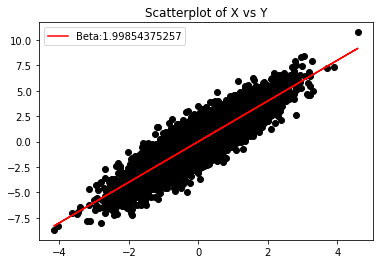

In [4]:
plt.scatter(x, y, color="black")
plt.plot(x, fit_fn(x), color='red')
plt.legend(["Beta:" + str(fit[0])])
plt.title("Scatterplot of X vs Y")
plt.show()

### Normal-Inverse Gamma Prior

In Bayesian linear regression, we put a prior distribution on the coeffients $\boldsymbol \beta$ and the variance $\sigma^2$. 

Here, for the coefficients we will assume a Gaussian prior (as it is conjugate to a Gaussian likelihood for our responses $\mathbf{y}$) with mean $\mathbf{0}$ and variance $\sigma^2 \mathbf{I}$. For $\sigma^2$ we will use an inverse Gamma prior with hyperparameters $a$ and $b$.

\begin{align}
 \boldsymbol \beta \mid \sigma^2 &\sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I}),\\
 \sigma^2 &\sim \mathcal{IG}(a, b).\\
\end{align}

Other choices of priors are of course also fine. For demonstration this will do, though. I refer to [Gelman's *Bayesian Data Analysis*](http://www.stat.columbia.edu/~gelman/book/) for more information.

The joint prior distribution is given by:

\begin{align}
 \boldsymbol \beta, \sigma^2 &\sim \mathcal{NIG}(\mathbf{0}, \mathbf{I}, a, b),\\
 p(\boldsymbol \beta, \sigma^2) &= p(\boldsymbol \beta \mid \sigma^2) \ p(\sigma^2) \\
 &= \frac{1}{ (2\pi\sigma^2)^{\frac{p}{2}}} \exp\left(  -\frac{1}{2\sigma^2}    \boldsymbol \beta^T \boldsymbol \beta \right) \frac{b^a}{\Gamma(a)} \frac{1}{(\sigma^2)^{a+1}} \exp\left(  -\frac{b}{\sigma^2} \right), \\
 &\propto \frac{1}{(\sigma^2)^{\frac{p}{2} + a + 1 }} \exp \left(  -\frac{1}{2\sigma^2} \boldsymbol \beta^T \boldsymbol \beta  -\frac{b}{\sigma^2}\right)
\end{align}

In the last part I removed every factor that does not depend on the variables $\boldsymbol \beta$ and $\sigma^2$.

Let's visualize these choices. First we draw $i \in \{1, \dots, 10000\}$ random samples $\sigma^2_i$ and then use these to sample coefficients $\boldsymbol \beta_i$. Both can be sampled directly using `scipy`, so we don't need to implement the random number generator.

In [5]:
a = 1
b = 1
m = 0
var = 1

sigma_prior = stats.invgamma.rvs(size=n, a=a, scale=b)
beta_prior = scipy.zeros(n)
for i in range(n):
    beta_prior[i] = stats.norm.rvs(size=1, loc=m, scale=sigma_prior[i] * var)

In [6]:
beta_prior

array([  7.97751576,   1.56743705, -29.18229685, ...,   0.0530105 ,
        -4.77214758,  -1.16903595])

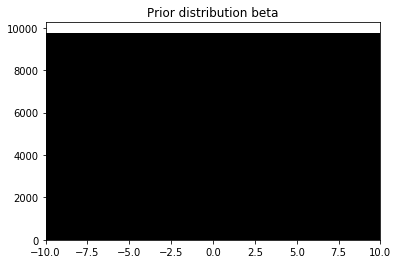

In [7]:
_, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.hist(beta_prior, bins=100, color="black")
plt.title("Prior distribution beta")
plt.show()

Our prior for $\boldsymbol \beta$ looks uniform, even though it is technically Gaussian. Still, since it is conjugate, we can determine the posterior distribution analytically.

### Normal-Inverse Gamma Posterior 

The posterior in a Bayesian model is proportional to the likelihood times the prior. As stated above, since the $\mathcal{NIG}$ prior is conjugate to the Gaussian likelihood, we will have a $\mathcal{NIG}$ posterior:

\begin{align}
  \text{posterior} &\propto \text{likelihood} \times \text{prior},\\
  p(\boldsymbol \beta, \sigma^2 \mid \mathbf{X}, \mathbf{y}) \propto \; &  p(\mathbf{y} \mid \mathbf{X}, \boldsymbol \beta, \sigma^2) \ p(\boldsymbol \beta , \sigma^2),\\
  p(\boldsymbol \beta, \sigma^2 \mid \mathbf{X}, \mathbf{y}) \propto \; & \frac{1}{(\sigma^2)^{\frac{n}{2}}} \exp \left( -\frac{1}{2\sigma^2} (\mathbf{y} - \mathbf{X} \boldsymbol \beta)^T(\mathbf{y} - \mathbf{X} \boldsymbol \beta)  \right)\\
 & \; \frac{1}{(\sigma^2)^{\frac{p}{2} + a + 1 }} \exp \left(  -\frac{1}{2\sigma^2} \boldsymbol \beta^T \boldsymbol \beta  -\frac{b}{\sigma^2}\right),\\
 = \; & \frac{1}{(\sigma^2)^{\frac{n}{2} + \frac{p}{2} + a + 1 }} \exp \left( -\frac{1}{2\sigma^2}  (\mathbf{y} - \mathbf{X} \boldsymbol \beta)^T(\mathbf{y} - \mathbf{X} \boldsymbol \beta)  -\frac{1}{2\sigma^2} \boldsymbol \beta^T \boldsymbol \beta  -\frac{b}{\sigma^2}  \right)
\end{align}

As for the prior above, if we want to generate particles, we need to decompose $p(\boldsymbol \beta, \sigma^2 \mid \mathbf{X}, \mathbf{y})$ into $p(\boldsymbol \beta \mid \mathbf{X}, \mathbf{y}, \sigma^2) \ p(\sigma^2 \mid \mathbf{X}, \mathbf{y}) $. The math is rather tedious, so I just give it here (adopted from [Murphy's book](https://mitpress.mit.edu/books/machine-learning-1)). First we derive the new hyper parameter values $a$ and $b$ for the variance $\sigma^2$ as well as mean and variance for $\boldsymbol \beta$.

\begin{align*}
p(\boldsymbol \beta, \sigma^2 \mid \mathbf{X}, \mathbf{y}) & = \mathcal{NIG}(\boldsymbol {\tilde{\mu}},\mathbf{\tilde{\Sigma}}, \tilde{a}, \tilde{b}),\\
\mathbf{\tilde{\Sigma}} &= (\mathbf{X}^T \mathbf{X} + \mathbf{I})^{-1},\\
\boldsymbol {\tilde{\mu}} &= \mathbf{\tilde{\Sigma}}\mathbf{X}^T \mathbf{y},\\
\tilde{a} &= a + \frac{n}{2},\\
\tilde{b} &= b + \frac{1}{2}(\mathbf{y}^T \mathbf{y} - \boldsymbol {\tilde{\mu}}^T \boldsymbol {\tilde{\Sigma}}^{-1}  \boldsymbol {\tilde{\mu}}) 
\end{align*}

In [8]:
var_tilde = 1 / (x.T.dot(x) + var)
m_tilde = var_tilde * x.T.dot(y)

a_tilde = a + n/2
b_tilde = b + .5 *( y.T.dot(y) - m_tilde * (1/var_tilde)* m_tilde)

Then we sample as above: first a particle from the posterior variance $p(\sigma^2 \mid \mathbf{y})$, then a particle from the conditional posterior $p(\boldsymbol \beta \mid  \mathbf{y}, \sigma^2)$.

In [9]:
sigma_post = stats.invgamma.rvs(size=n, a=a_tilde, scale=b_tilde)
beta_post = scipy.zeros(n)
for i in range(n):
    beta_post[i] = stats.norm.rvs(size=1, loc=m_tilde, scale=sigma_post[i] * m_tilde)

Let's visualize this again:

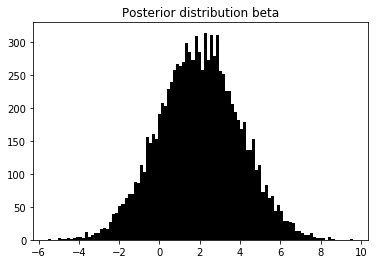

In [10]:
_, ax = plt.subplots()
ax.hist(beta_post, bins=100, color="black")
ax.lines
plt.title("Posterior distribution beta")
plt.show()

## Probabilistic programming languages

It is rather unnessecary to implement these things yourself, especially for non-analytical solutions. For this tutorial we use `PyMC3` to create the model, since we don't need `Edward`'s tensorflow backend.

In [11]:
import pymc3

In [12]:
model = pymc3.Model()
with model:
    sigma = pymc3.InverseGamma('sigma', 1, 1)
    beta = pymc3.Normal("beta", mu=0, sd=sigma)
    mu = x*beta
    y_model = pymc3.Normal("Y", mu=mu, sd=sigma, observed=y)
model

In [13]:
with model:
    trace = pymc3.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, sigma_log__]
100%|██████████| 1500/1500 [00:06<00:00, 226.49it/s]


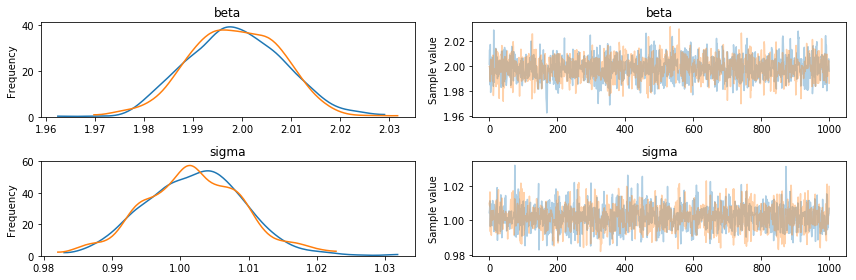

In [14]:
pymc3.traceplot(trace)
plt.show()

In [15]:
pymc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,1.998542,0.009585,0.000245,1.980800,2.016965,1970.746687,0.999502
sigma,1.001999,0.007192,0.000153,0.988146,1.016780,2178.049637,0.999782
